Current directory: /Users/abdulsalam/EAS-508-Data-Science-Project
=== MODEL DEVELOPMENT ===
✓ File found: data/interim/pbp_2023_featured.csv


/var/folders/49/vm1jcskx3vg1j0qp06k8rrdw0000gn/T/ipykernel_23282/3551558391.py:24: DtypeWarning: Columns (72,202,203,205,206,210,211,212,213,214,215,222,223,228,229,236,237,238,239,240,241,242,243,245,247,249,269,270,271,272,273,274,275,276,277,278,279,281,282,283,285,286,287,288,289,290,291,292,293,295,296,297,300,301,306,307,355) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Data shape: (38941, 400)

=== DATA EXPLORATION ===
Success rate: 0.4386379394468555
Down distribution:
down
1.0    15452
2.0    11777
3.0     7482
4.0     4230
Name: count, dtype: int64

Using 7 features: ['down', 'ydstosuccess', 'yardline_100', 'score_differential', 'in_redzone', 'previous_success', 'offense_formation']
Final dataset: (35383, 7)
Categorical features: ['offense_formation']

Training set: (28306, 7)
Test set: (7077, 7)

=== TRAINING CATBOOST MODEL ===
0:	learn: 0.5931251	test: 0.5871132	best: 0.5871132 (0)	total: 5.22ms	remaining: 2.6s
100:	learn: 0.5977885	test: 0.5886675	best: 0.5892327 (95)	total: 583ms	remaining: 2.3s
200:	learn: 0.5998022	test: 0.5865480	best: 0.5892327 (95)	total: 1.13s	remaining: 1.68s
300:	learn: 0.6045361	test: 0.5888088	best: 0.5895153 (297)	total: 1.72s	remaining: 1.14s
400:	learn: 0.6101533	test: 0.5905045	best: 0.5906458 (396)	total: 2.28s	remaining: 563ms
499:	learn: 0.6143927	test: 0.5910697	best: 0.5916349 (483)	total: 2.83s	remaining: 0

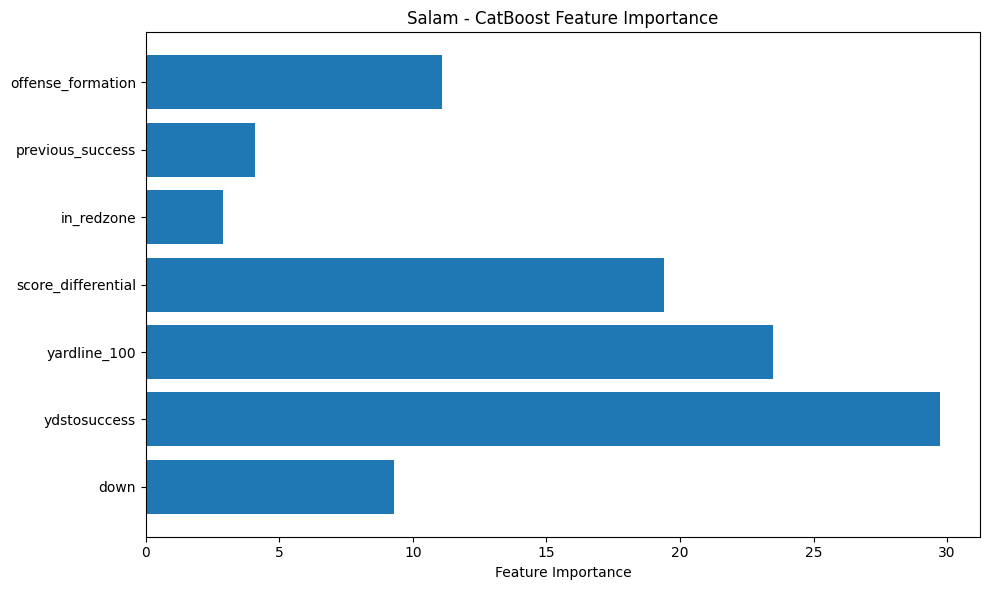

In [13]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

NOTEBOOK_DIR = os.getcwd()
print('Current directory:', NOTEBOOK_DIR)

if "notebooks" in NOTEBOOK_DIR:
    os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
    print('Changed to project root:', os.getcwd())

print("=== MODEL DEVELOPMENT ===")

file_path = 'data/interim/pbp_2023_featured.csv'
if os.path.exists(file_path):
    print(f"✓ File found: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Data shape: {df.shape}")
else:
    print(f"✗ File not found: {file_path}")
    print("Available files in data/interim/:")
    try:
        files = os.listdir('data/interim/')
        for f in files:
            print(f"  - {f}")
        if files:
            first_file = files[0]
            print(f"Using: {first_file}")
            df = pd.read_csv(f'data/interim/{first_file}')
    except Exception as e:
        print(f"Error: {e}")
        exit()

print("\n=== DATA EXPLORATION ===")
print("Success rate:", df['success'].mean())
print("Down distribution:")
print(df['down'].value_counts().sort_index())

features = [
    'down', 'ydstosuccess', 'yardline_100', 'score_differential',
    'in_redzone', 'previous_success', 'offense_formation'
]

available_features = [f for f in features if f in df.columns]
target = 'success'

print(f"\nUsing {len(available_features)} features: {available_features}")

model_data = df[available_features + [target]].dropna()
X = model_data[available_features]
y = model_data[target]

print(f"Final dataset: {X.shape}")

cat_features = [f for f in available_features if X[f].dtype == 'object']
print(f"Categorical features: {cat_features}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print("\n=== TRAINING CATBOOST MODEL ===")
cat_model = CatBoostClassifier(
    cat_features=cat_features,
    iterations=500,  
    learning_rate=0.05,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred = cat_model.predict(X_test)
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]

print("\n=== CATBOOST RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

feature_importance = cat_model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(available_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Salam - CatBoost Feature Importance')
plt.tight_layout()
plt.show()
